#HOMEWORK

MRR
Исходные данные - результат generate_subsample

Задача - по аналогии с precision написать три версии функции подсчета Mean Reciprocal Rank (naive, numba, pandas) и протестировать на разных размерах выборки

Протестируйте для всех комбинаций (users_count, top_k):
users_count - [100, 1000, 10000, 100000]
top_k - [10, 50, 100]
Результатом тестирования должен быть график, где будут отражены следующие показатели:
Алгоритм - naive, numba, pandas
Скорость работы (время)
users_count
top_k

Mean Reciprocal Rank

- Считаем для первых k рекоммендаций
- Найти ранк первого релевантного предсказания $k_u$
- Посчитать reciprocal rank = $\frac{1}{k_u}$

$$MRR = mean(\frac{1}{k_u})$$


In [ ]:
!pip install rectools

In [1]:
import pandas as pd
import numpy as np
import numba as nb
import timeit
import requests
from tqdm.auto import tqdm
from rectools import Columns
from matplotlib import pyplot as plt

In [2]:
np.random.seed(23)

#Get KION dataset

In [7]:
url = 'https://github.com/irsafilo/KION_DATASET/raw/f69775be31fa5779907cf0a92ddedb70037fb5ae/data_original.zip'
req = requests.get(url, stream=True)

with open('kion.zip', 'wb') as fd:
    total_size_in_bytes = int(req.headers.get('Content-Length', 0))
    progress_bar = tqdm(desc='kion dataset download', total=total_size_in_bytes, unit='iB', unit_scale=True)
    for chunk in req.iter_content(chunk_size=2 ** 20):
        progress_bar.update(len(chunk))
        fd.write(chunk)

kion dataset download:   0%|          | 0.00/78.8M [00:00<?, ?iB/s]

In [8]:
!unzip kion.zip

Archive:  kion.zip
   creating: data_original/
  inflating: data_original/interactions.csv  
  inflating: __MACOSX/data_original/._interactions.csv  
  inflating: data_original/users.csv  
  inflating: __MACOSX/data_original/._users.csv  
  inflating: data_original/items.csv  
  inflating: __MACOSX/data_original/._items.csv  


In [3]:
# Read data
interactions = pd.read_csv('data_original/interactions.csv')

interactions.rename(
    columns={
        'track_id': Columns.Item,
        'last_watch_dt': Columns.Datetime,
        'total_dur': Columns.Weight
    }, 
    inplace=True) 

In [4]:
interactions[Columns.Datetime] = pd.to_datetime(interactions[Columns.Datetime])

In [5]:
users = pd.read_csv('data_original/users.csv')
items = pd.read_csv('data_original/items.csv')

In [6]:
def headtail(df):
    return pd.concat([df.head(), df.tail()])

headtail(interactions)

,user_id,item_id,datetime,weight,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
5476246,648596,12225,2021-08-13,76,0.0
5476247,546862,9673,2021-04-13,2308,49.0
5476248,697262,15297,2021-08-20,18307,63.0
5476249,384202,16197,2021-04-19,6203,100.0
5476250,319709,4436,2021-08-15,3921,45.0


In [13]:
interactions.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5476251 entries, 0 to 5476250
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   user_id      int64         
 1   item_id      int64         
 2   datetime     datetime64[ns]
 3   weight       int64         
 4   watched_pct  float64       
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 208.9 MB


In [7]:
def generate_subsample(users_count, top_k):
    users = np.random.choice(interactions[Columns.User].unique(), users_count, replace=False)
    df = interactions[interactions[Columns.User].isin(users)].reset_index(drop=True)
    del df[Columns.Datetime], df[Columns.Weight], df['watched_pct']
    
    recs = np.random.choice(df[Columns.Item], size=(users_count, top_k))
    return df, users, recs

In [8]:
top_k = 10
df, users, recs = generate_subsample(10000, top_k)
df

,user_id,item_id
0,513902,3614
1,447592,1241
2,179618,9988
3,217915,6563
4,1074210,15930
...,...,...
56725,358802,10636
56726,373637,9728
56727,83436,5411
56728,609195,6258


In [9]:
users.shape, recs.shape

((10000,), (10000, 10))

In [10]:
recs

array([[ 2657, 10077,  9728, ...,  3379,  3734,  5452],
       [ 6033, 14607,   142, ...,  9728,  2780,  9728],
       [  285,  9982,  4151, ...,  4151,  8419,  7662],
       ...,
       [ 6968, 14703, 11586, ...,  9996, 12808, 15297],
       [13865,  7164,  7417, ...,  7102, 16228,  1105],
       [10316,  5635,  7799, ...,  3384,  9817, 13882]])

In [11]:
target = df.values

In [12]:
target[0]

array([513902,   3614])

In [13]:
def naive_mrr(target: np.ndarray, users: np.ndarray, recs: np.ndarray):
    mrr = 0
    for i, user in enumerate(users):
        res = 0
        user_target = target[target[:, 0] == user][:, 1]
        for j, rec in enumerate(recs[i]):
            if rec in user_target:
                res = 1/(j+1)
                break
        mrr += res
    return mrr / len(users)

In [14]:
naive_mrr(target, users, recs)

0.07836801587301619

In [15]:
@nb.njit(cache=True, parallel=True)
def numba_mrr(target: np.ndarray, users: np.ndarray, recs: np.ndarray):
    mrr = np.zeros(len(users))
    for i in nb.prange(len(users)):
        user = users[i]
        p = 0
        user_target = target[target[:, 0] == user][:, 1]
        for j, rec in enumerate(recs[i]):
            if rec in user_target:
                p = 1/(j+1)
                break
        mrr[i] = p
    return mrr.mean()

In [16]:
numba_mrr(target, users, recs)

0.07836801587301577

In [17]:
def pandas_mrr(df: pd.DataFrame, users: np.ndarray, recs: np.ndarray):
    k = recs.shape[1]
    MAX_RANK = 100000
    df_recs = pd.DataFrame({
        Columns.User: np.repeat(users, k),
        Columns.Item: recs.ravel()
    })
    df_recs[Columns.Rank] = df_recs.groupby(Columns.User).cumcount() + 1
    df_recs = df.merge(df_recs, how='left', left_on=Columns.UserItem, right_on=Columns.UserItem).fillna(MAX_RANK)

    mrr = (1 / df_recs.groupby('user_id')['rank'].min()).mean()
    return mrr

In [18]:
pandas_mrr(df, users, recs)

0.07837570687301587

In [72]:
elapsed_time = timeit.timeit('pandas_mrr(df, users, recs)', "from __main__ import pandas_mrr, df, target, users, recs", number=100)/100

In [73]:
elapsed_time

0.05222157385000173

In [22]:
%timeit
list_users_count = [100, 1000, 10000, 100000] 
list_top_k = [10, 50, 100]
c_len = len(list_users_count)
k_len = len(list_top_k)
time_naive = np.empty((c_len, k_len))
time_numba = np.empty(((c_len, k_len)))
time_pd = np.empty(((c_len, k_len)))

for i, user_count in enumerate(tqdm(list_users_count)):
    for j, top_k in enumerate(list_top_k):
        df, users, recs = generate_subsample(user_count, top_k)
        target = df.values
        
        time_naive[i][j] = timeit.timeit('naive_mrr(target, users, recs)', setup="from __main__ import naive_mrr, target, users, recs", number=1) / 1
        time_numba[i][j] = timeit.timeit('numba_mrr(target, users, recs)', setup="from __main__ import numba_mrr, target, users, recs", number=1) / 1
        time_pd[i][j] = timeit.timeit('pandas_mrr(df, users, recs)', setup="from __main__ import pandas_mrr, df, users, recs", number=1) / 1

  0%|          | 0/4 [00:00<?, ?it/s]

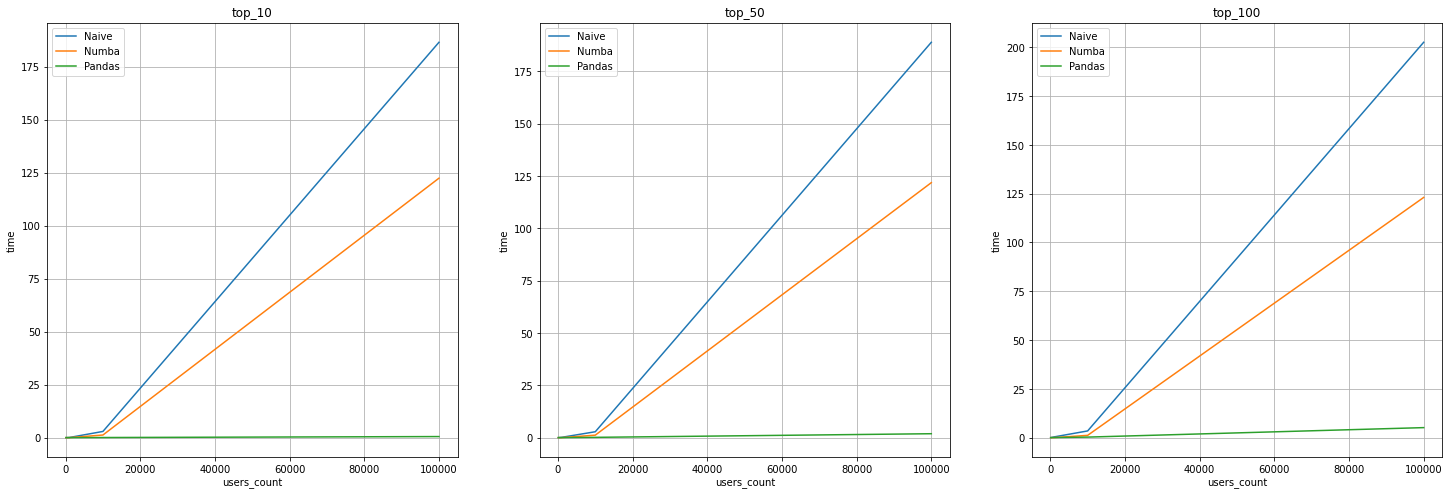

In [36]:
fig, axis = plt.subplots(1, k_len, figsize=(25, 8))
for i in range(k_len):
    axis[i].plot(list_users_count, time_naive[:, i], label='Naive')
    axis[i].plot(list_users_count, time_numba[:, i], label='Numba')
    axis[i].plot(list_users_count, time_pd[:, i], label='Pandas')
    axis[i].set_title(f'top_{list_top_k[i]}')
    axis[i].legend()
    axis[i].set_xlabel('users_count')
    axis[i].set_ylabel('time')
    axis[i].grid()
    
plt.show()